In [1]:
# Install missing libraries (if needed)
!pip install joblib matplotlib scikit-learn

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
import joblib
import matplotlib.pyplot as plt


In [2]:
# Load built-in Breast Cancer dataset
data = load_breast_cancer(as_frame=True)

df = data.frame.copy()
df['target'] = data.target

df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
print(df.info())
print(df.isnull().sum())
print(df['target'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [4]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear', max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [7]:
def evaluate_model(name, model, X_eval, y_true, scaled=False):
    if scaled:
        X_eval = scaler.transform(X_eval)

    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)[:, 1]

    print(f"\n----- {name} -----")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))


In [8]:
evaluate_model("Logistic Regression", lr, X_test, y_test, scaled=True)
evaluate_model("Random Forest", rf, X_test, y_test, scaled=False)



----- Logistic Regression -----
Accuracy: 0.9824561403508771
ROC AUC: 0.9957010582010581

Confusion Matrix:
 [[41  1]
 [ 1 71]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


----- Random Forest -----
Accuracy: 0.956140350877193
ROC AUC: 0.9930555555555556

Confusion Matrix:
 [[39  3]
 [ 2 70]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [9]:
cv_lr = cross_val_score(lr, scaler.transform(X), y, cv=5, scoring='accuracy')
cv_rf = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

print("Logistic Regression CV Mean Accuracy:", cv_lr.mean())
print("Random Forest CV Mean Accuracy:", cv_rf.mean())


Logistic Regression CV Mean Accuracy: 0.9789318428815402
Random Forest CV Mean Accuracy: 0.9578481602235678


In [10]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10)


,0
worst perimeter,0.133100
worst area,0.128052
worst concave points,0.108107
mean concave points,0.094414
worst radius,0.090639
mean radius,0.058662
mean perimeter,0.055242
mean area,0.049938
mean concavity,0.046207
worst concavity,0.035357


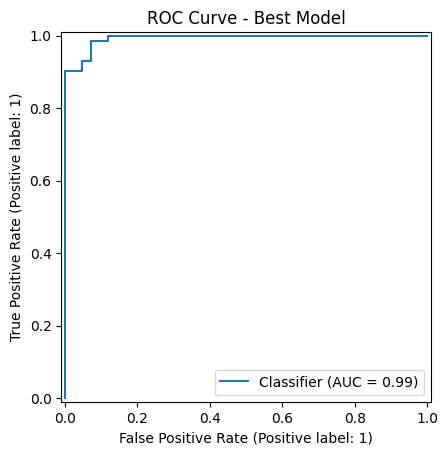

In [11]:
best_model = rf  # You may choose lr if LR performs better

X_plot = X_test
y_prob = best_model.predict_proba(X_plot)[:, 1]

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve - Best Model")
plt.show()


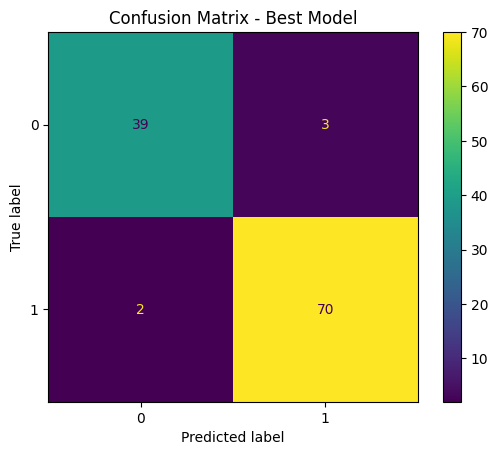

In [12]:
y_pred = best_model.predict(X_plot)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Best Model")
plt.show()


In [13]:
joblib.dump(best_model, "breast_cancer_best_model.joblib")
joblib.dump(scaler, "breast_cancer_scaler.joblib")

print("Model saved as breast_cancer_best_model.joblib")
print("Scaler saved as breast_cancer_scaler.joblib")


Model saved as breast_cancer_best_model.joblib
Scaler saved as breast_cancer_scaler.joblib


In [14]:
sample = X_test.head(10)
sample_scaled = scaler.transform(sample)

preds = best_model.predict(sample)
probs = best_model.predict_proba(sample)[:, 1]

df_pred = sample.copy()
df_pred['true_label'] = y_test.loc[sample.index].values
df_pred['prediction'] = preds
df_pred['prob_malignant'] = probs

df_pred


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,true_label,prediction,prob_malignant
256,19.550,28.77,133.60,1207.0,0.09260,0.20630,0.17840,0.11440,0.1893,0.06232,...,1926.0,0.1281,0.53290,0.42510,0.19410,0.2818,0.10050,0,0,0.000
428,11.130,16.62,70.47,381.1,0.08151,0.03834,0.01369,0.01370,0.1511,0.06148,...,421.1,0.1030,0.06219,0.04580,0.04044,0.2383,0.07083,1,1,1.000
501,13.820,24.49,92.33,595.9,0.11620,0.16810,0.13570,0.06759,0.2275,0.07237,...,788.0,0.1794,0.39660,0.33810,0.15210,0.3651,0.11830,0,0,0.120
363,16.500,18.29,106.60,838.1,0.09686,0.08468,0.05862,0.04835,0.1495,0.05593,...,1009.0,0.1338,0.16790,0.16630,0.09123,0.2394,0.06469,1,0,0.255
564,21.560,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,2027.0,0.1410,0.21130,0.41070,0.22160,0.2060,0.07115,0,0,0.010
464,13.170,18.22,84.28,537.3,0.07466,0.05994,0.04859,0.02870,0.1454,0.05549,...,687.6,0.1282,0.19650,0.18760,0.10450,0.2235,0.06925,1,1,0.985
358,8.878,15.49,56.74,241.0,0.08293,0.07698,0.04721,0.02381,0.1930,0.06621,...,302.0,0.1015,0.12480,0.09441,0.04762,0.2434,0.07431,1,1,0.970
343,19.680,21.68,129.90,1194.0,0.09797,0.13390,0.18630,0.11030,0.2082,0.05715,...,1540.0,0.1218,0.34580,0.47340,0.22550,0.4045,0.07918,0,0,0.005
516,18.310,20.58,120.80,1052.0,0.10680,0.12480,0.15690,0.09451,0.1860,0.05941,...,1493.0,0.1492,0.25360,0.37590,0.15100,0.3074,0.07863,0,0,0.000
567,20.600,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,1821.0,0.1650,0.86810,0.93870,0.26500,0.4087,0.12400,0,0,0.000
